# Fitting more complex models to photometry with Bagpipes

In the previos example we covered some of the basics, now let's look at fitting a more complex model.

## Setting up

Once again we'll need to load up the observational data, we'll use the same object as last time.

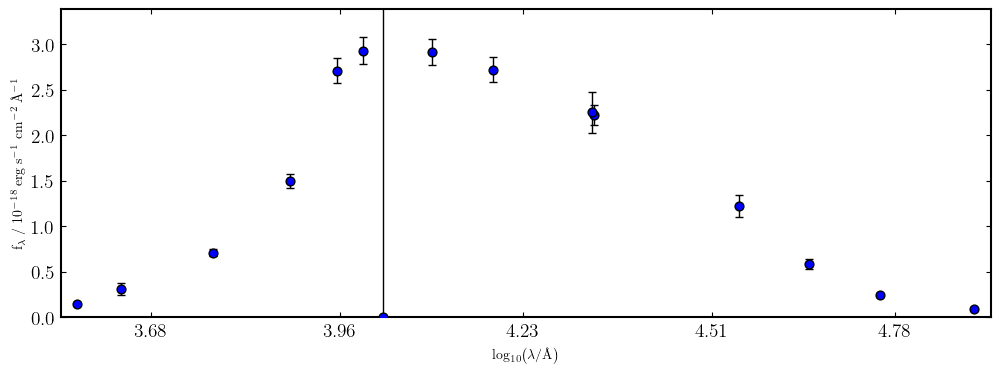

In [1]:
import numpy as np 
import bagpipes as pipes

from astropy.io import fits

def load_goodss(ID):
    """ Load CANDELS GOODS South photometry from the Guo et al. (2013) catalogue. """

    # load up the relevant columns from the catalogue.
    cat = np.loadtxt("hlsp_candels_hst_wfc3_goodss-tot-multiband_f160w_v1-1photom_cat.txt",
                     usecols=(10, 13, 16, 19, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55,
                              11, 14, 17, 20, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56))
    
    # Find the correct row for the object we want.
    row = int(ID) - 1

    # Extract the object we want from the catalogue.
    fluxes = cat[row, :15]
    fluxerrs = cat[row, 15:]

    # Turn these into a 2D array.
    photometry = np.c_[fluxes, fluxerrs]

    # blow up the errors associated with any missing fluxes.
    for i in range(len(photometry)):
        if (photometry[i, 0] == 0.) or (photometry[i, 1] <= 0):
            photometry[i,:] = [0., 9.9*10**99.]
            
    # Enforce a maximum SNR of 20, or 10 in the IRAC channels.
    for i in range(len(photometry)):
        if i < 10:
            max_snr = 20.
            
        else:
            max_snr = 10.
        
        if photometry[i, 0]/photometry[i, 1] > max_snr:
            photometry[i, 1] = photometry[i, 0]/max_snr

    return photometry

goodss_filt_list = np.loadtxt("filters/goodss_filt_list.txt", dtype="str")

galaxy = pipes.galaxy("17433", load_goodss, spectrum_exists=False, filt_list=goodss_filt_list)

fig = galaxy.plot()

## Making a more interesting model

Instead of an ordinary tau model let's try fitting a double-power-law star-formation history, we'll also include nebular emission this time. This is also a good time to think about the priors we're imposing on our fitting parameters. By default Bagpipes will fit a uniform prior between the limits you set, but you can change that as follows:

In [2]:
dblplaw = {}                        
dblplaw["tau"] = (0., 15.)                # Vary the time of peak star-formation between
                                          # the Big Bang at 0 Gyr and 15 Gyr later. In 
                                          # practice the code automatically stops this
                                          # exceeding the age of the universe at the 
                                          # observed redshift.
            
dblplaw["alpha"] = (0.01, 1000.)          # Vary the falling power law slope from 0.01 to 1000.
dblplaw["beta"] = (0.01, 1000.)           # Vary the rising power law slope from 0.01 to 1000.
dblplaw["alpha_prior"] = "log_10"         # Impose a prior which is uniform in log_10 of the 
dblplaw["beta_prior"] = "log_10"          # parameter between the limits which have been set 
                                          # above as in Carnall et al. (2017).
dblplaw["massformed"] = (1., 15.)
dblplaw["metallicity"] = (0., 2.5)

dust = {}                           
dust["type"] = "Calzetti"
dust["Av"] = (0., 2.)

nebular = {}
nebular["logU"] = -3.

fit_info = {}                            # The fit instructions dictionary
fit_info["redshift"] = (0., 10.)         # Vary observed redshift from 0 to 10

fit_info["redshift_prior"] = "Gaussian"  # From looking at the spectrum in Example 2 it's
fit_info["redshift_prior_mu"] = 1.0      # clear that this  object is at around z = 1. We'll 
fit_info["redshift_prior_sigma"] = 0.25  # include that information with a broad Gaussian
                                         # prior centred on redshift 1. Parameters of priors
                                         # are passed starting with "parameter_prior_".
fit_info["dblplaw"] = dblplaw 
fit_info["dust"] = dust
fit_info["nebular"] = nebular

# Fitting the same object multiple times with different runs

Now we're ready to fit the object, but there's a problem, the posterior distribution for the previous example is still there. We can fit a fresh model without deleting our previous outputs by setting the run keyword argument of the fit object, which causes the output posterior to be saved under "pipes/posterior/run" instead "pipes/posterior" and the same for output plots.


Bagpipes: fitting object 17433


Completed in 213.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dblplaw:alpha                 72.660    227.627    599.798
dblplaw:beta                   0.066      0.966     27.793
dblplaw:massformed            11.044     11.175     11.242
dblplaw:metallicity            0.712      1.152      1.681
dblplaw:tau                    4.458      4.851      5.090
dust:Av                        0.249      0.417      0.578
redshift                       1.015      1.053      1.092




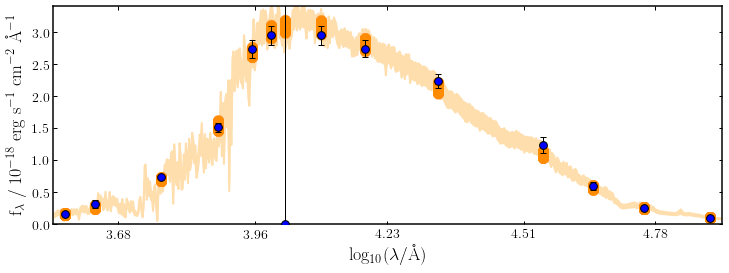

In [3]:
fit = pipes.fit(galaxy, fit_info, run="dblplaw_sfh")

fit.fit(verbose=False)

fig = fit.plot_spectrum_posterior(save=False, show=True)

That's about it for fitting photometry, go on to the next example to learn about fitting spectroscopy.